## Import libraries

In [1]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as nps
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

2021-09-30 04:31:39.135549: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Get The Images

In [2]:
with zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r') as z :
    z.extractall()

In [4]:
filenames = os.listdir("./train")
categories = []
for image in filenames :
    category = image.split('.')[0]
    if category == 'dog' :
        categories.append(1)
    else :    
        categories.append(0)

In [5]:
df = pd.DataFrame({'filename' : filenames, 'category' : categories})
df.head()

,filename,category
0,cat.11053.jpg,0
1,dog.6616.jpg,1
2,cat.6559.jpg,0
3,dog.706.jpg,1
4,dog.11952.jpg,1


In [6]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

## Show some images 

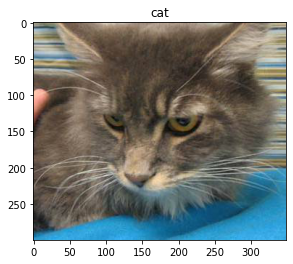

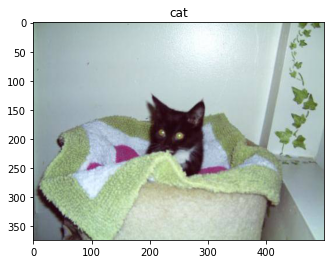

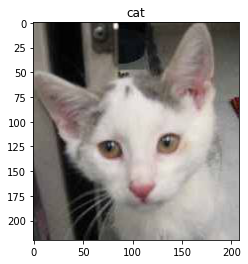

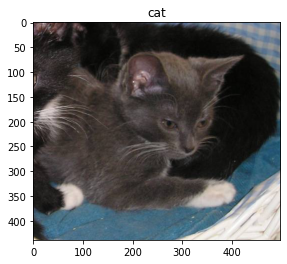

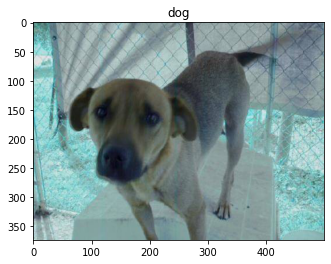

In [7]:
for i in range(5) :
    sample = filenames[i+10]
    image = tf.keras.preprocessing.image.load_img('./train/' + sample)
    plt.imshow(image)
    plt.title('dog' if categories[i+10]==1 else 'cat')
    plt.show()

## Define The Model 

In [8]:
#model 
model = keras.models.Sequential()

##  Conv_1
model.add(keras.layers.Conv2D(32, 3,input_shape = [128, 128, 3], activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_2
model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_3
model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Conv_4
model.add(keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D(2))
model.add(keras.layers.Dropout(0.2))

## Flatten
model.add(keras.layers.Flatten())

## fc_1
model.add(keras.layers.Dense(1024, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))

## fc_2
model.add(keras.layers.Dense(2, activation = 'sigmoid'))

## optimizer and loss
#optimizer = keras.optimizers.RMSprop(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

model.summary()

2021-09-30 04:33:20.361676: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-30 04:33:20.365664: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-30 04:33:20.406875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-30 04:33:20.407509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-30 04:33:20.407579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-30 04:33:20.433909: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [9]:
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Data Preparation


1. Encoding labels

In [10]:
df['category'] = df['category'].map({0 : 'cat', 1 : 'dog'})

2. Create Validation Set

In [11]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [13]:
train_df.head()

,filename,category
0,cat.11015.jpg,cat
1,dog.6569.jpg,dog
2,cat.12054.jpg,cat
3,dog.5795.jpg,dog
4,dog.4366.jpg,dog


In [15]:
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
batch_size = 10

## Train Generator

In [16]:
train_data = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                         rescale = 1./255,
                                                         horizontal_flip=True)
train_generator = train_data.flow_from_dataframe(train_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.


## Valid Generator

In [17]:
valid_data = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
                                                         
                                                         
valid_generator = valid_data.flow_from_dataframe(valid_df,
                                                './train/',
                                                x_col = 'filename',
                                                y_col = 'category',
                                                target_size=[128,128],
                                                class_mode='categorical',
                                                batch_size=batch_size)


Found 5000 validated image filenames belonging to 2 classes.


## Training Model 

In [19]:
epochs = 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=total_valid//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks)


Epoch 1/10
2000/2000 [==============================] - 142s 71ms/step - loss: 0.5890 - accuracy: 0.7182 - val_loss: 1.4569 - val_accuracy: 0.6174
Epoch 2/10
2000/2000 [==============================] - 142s 71ms/step - loss: 0.5316 - accuracy: 0.7694 - val_loss: 0.4324 - val_accuracy: 0.8228
Epoch 3/10
2000/2000 [==============================] - 143s 72ms/step - loss: 0.4873 - accuracy: 0.8020 - val_loss: 0.4297 - val_accuracy: 0.8042
Epoch 4/10
2000/2000 [==============================] - 144s 72ms/step - loss: 0.4561 - accuracy: 0.8178 - val_loss: 1.0111 - val_accuracy: 0.7176
Epoch 5/10
2000/2000 [==============================] - 145s 72ms/step - loss: 0.4383 - accuracy: 0.8297 - val_loss: 0.8250 - val_accuracy: 0.7914
Epoch 6/10
2000/2000 [==============================] - 144s 72ms/step - loss: 0.4150 - accuracy: 0.8390 - val_loss: 0.3122 - val_accuracy: 0.8780
Epoch 7/10
2000/2000 [==============================] - 142s 71ms/step - loss: 0.3912 - accuracy: 0.8438 - val_loss: 0

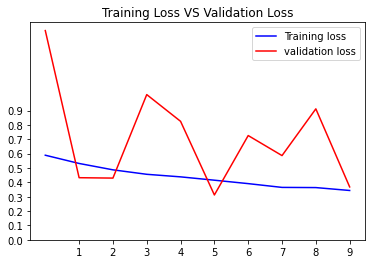

In [20]:
import numpy as np
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend()
plt.title('Training Loss VS Validation Loss')
plt.show()

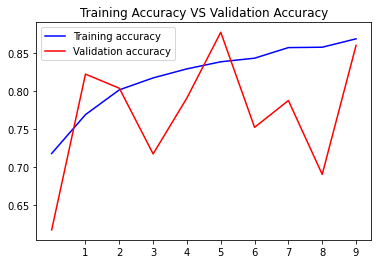

In [21]:
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.xticks(np.arange(1, epochs, 1))
plt.title('Training Accuracy VS Validation Accuracy')
plt.legend()
plt.show()

## Prepaing Test Data

In [22]:
with zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as z :
    z.extractall()

In [23]:
filenames = os.listdir("./test1")
test_df = pd.DataFrame({'filename' : filenames})    
samples = test_df.shape[0]

In [24]:
test_data = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_dataframe(
    test_df, 
    "./test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=[128,128],
    batch_size=batch_size,
    shuffle=False)

Found 12500 validated image filenames.


In [25]:
predict = model.predict_generator(test_generator, steps=np.ceil(samples/batch_size))


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [27]:
test_df.head()

,filename,category
0,7016.jpg,0
1,11733.jpg,1
2,7847.jpg,1
3,10680.jpg,0
4,453.jpg,1


In [35]:
categories = test_df.category.to_list()
test_pics =test_df.filename.to_list()

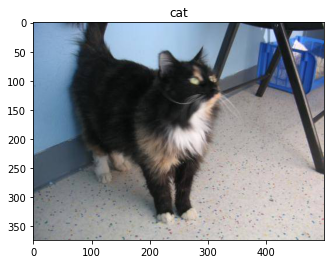

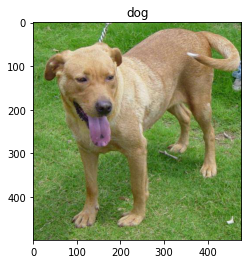

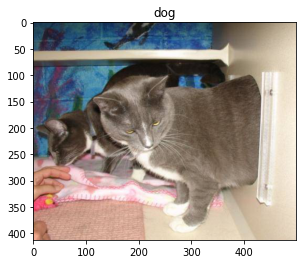

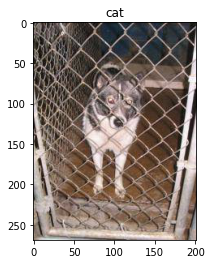

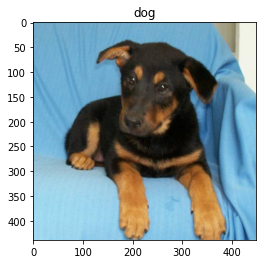

In [36]:
for i in range(5) :
    sample = test_pics[i]
    image = tf.keras.preprocessing.image.load_img('./test1/' + str(sample))
    plt.imshow(image)
    plt.title('dog' if categories[i]==1 else 'cat')
    plt.show()